# Abstractive Text Summarizor


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Change the working directory
import os
import gc
os.chdir('/content/gdrive/My Drive/NLP/Text Summarization/Abstractive Text Summarization')
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.listdir()

['Dataset',
 'Cellstrat',
 'Abstractive Text Summarization - Pre Processing.ipynb',
 'attention.py',
 '__pycache__',
 'Abstractive Text Summarization - Model.ipynb',
 'Cellstrat - Abstractive Text Summarization.ipynb']

In [0]:
from attention import AttentionLayer

In [4]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [5]:
reviews_dataset = pd.read_csv("Dataset/Food Reviews.csv")
reviews_dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


## Drop Duplicates and NA values

In [0]:
reviews_dataset.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
reviews_dataset.dropna(axis=0,inplace=True)#dropping na

## Preprocessing

In [0]:
# Removing Contractions
contractions = {"ain't": "is not", 
                       "aren't": "are not",
                       "can't": "cannot", 
                       "'cause": "because", 
                       "could've": "could have", 
                       "couldn't": "could not",
                       "didn't": "did not",  
                       "doesn't": "does not", 
                       "don't": "do not", 
                       "hadn't": "had not", 
                       "hasn't": "has not", 
                       "haven't": "have not",
                       "he'd": "he would",
                       "he'll": "he will", 
                       "he's": "he is", 
                       "how'd": "how did", 
                       "how'd'y": "how do you", 
                       "how'll": "how will", 
                       "how's": "how is",
                       "I'd": "I would", 
                       "I'd've": "I would have", 
                       "I'll": "I will", 
                       "I'll've": "I will have",
                       "I'm": "I am", 
                       "I've": "I have", 
                       "i'd": "i would",
                       "i'd've": "i would have", 
                       "i'll": "i will",  
                       "i'll've": "i will have",
                       "i'm": "i am", 
                       "i've": "i have", 
                       "isn't": "is not", 
                       "it'd": "it would",
                       "it'd've": "it would have", 
                       "it'll": "it will", 
                       "it'll've": "it will have",
                       "it's": "it is", 
                       "let's": "let us", 
                       "ma'am": "madam",
                       "mayn't": "may not", 
                       "might've": "might have",
                       "mightn't": "might not",
                       "mightn't've": "might not have", 
                       "must've": "must have",
                       "mustn't": "must not", 
                       "mustn't've": "must not have", 
                       "needn't": "need not", 
                       "needn't've": "need not have",
                       "o'clock": "of the clock",
                       "oughtn't": "ought not", 
                       "oughtn't've": "ought not have", 
                       "shan't": "shall not", 
                       "sha'n't": "shall not", 
                       "shan't've": "shall not have",
                       "she'd": "she would", 
                       "she'd've": "she would have", 
                       "she'll": "she will", 
                       "she'll've": "she will have", 
                       "she's": "she is",
                       "should've": "should have", 
                       "shouldn't": "should not", 
                       "shouldn't've": "should not have", 
                       "so've": "so have",
                       "so's": "so as",
                       "this's": "this is",
                       "that'd": "that would", 
                       "that'd've": "that would have", 
                       "that's": "that is", 
                       "there'd": "there would",
                       "there'd've": "there would have", 
                       "there's": "there is", 
                       "here's": "here is",
                       "they'd": "they would", 
                       "they'd've": "they would have",
                       "they'll": "they will", 
                       "they'll've": "they will have", 
                       "they're": "they are", 
                       "they've": "they have", 
                       "to've": "to have",
                       "wasn't": "was not", 
                       "we'd": "we would", 
                       "we'd've": "we would have", 
                       "we'll": "we will", 
                       "we'll've": "we will have", 
                       "we're": "we are",
                       "we've": "we have", 
                       "weren't": "were not", 
                       "what'll": "what will", 
                       "what'll've": "what will have", 
                       "what're": "what are",
                       "what's": "what is", 
                       "what've": "what have", 
                       "when's": "when is", 
                       "when've": "when have", 
                       "where'd": "where did", 
                       "where's": "where is",
                       "where've": "where have", 
                       "who'll": "who will", 
                       "who'll've": "who will have", 
                       "who's": "who is", 
                       "who've": "who have",
                       "why's": "why is", 
                       "why've": "why have", 
                       "will've": "will have", 
                       "won't": "will not", 
                       "won't've": "will not have",
                       "would've": "would have", 
                       "wouldn't": "would not", 
                       "wouldn't've": "would not have", 
                       "y'all": "you all",
                       "y'all'd": "you all would",
                       "y'all'd've": "you all would have",
                       "y'all're": "you all are",
                       "y'all've": "you all have",
                       "you'd": "you would", 
                       "you'd've": "you would have", 
                       "you'll": "you will", 
                       "you'll've": "you will have",
                       "you're": "you are", 
                       "you've": "you have"}

In [0]:
def remove_contractions(text):
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
    return text

In [9]:
#We must get the values in lower case before calling remove_contraction method
reviews_dataset['Cleaned_Text'] = reviews_dataset.Text.str.lower().apply(lambda x: remove_contractions(x))
reviews_dataset['Cleaned_Summary'] = reviews_dataset.Summary.str.lower().apply(lambda x: remove_contractions(x))
reviews_dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labr...,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".","product arrived labeled as jumbo salted peanuts...the peanuts were actually small sized unsalted. not sure if this was an error or if the vendor intended to represent the product as ""jumbo"".",not as advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","this is a confection that has been around a few centuries. it is a light, pillowy citrus gelatin with nuts - in this case filberts. and it is cut into tiny squares and then liberally coated with p...","""delight"" says it all"
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,if you are looking for the secret ingredient in robitussin i believe i have found it. i got this in addition to the root beer extract i ordered (which was good) and made some cherry soda. the flav...,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.","great taffy at a great price. there was a wide assortment of yummy taffy. delivery was very quick. if your a taffy lover, this is a deal.",great taffy


In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#call the function
cleaned_text = []
for text in reviews_dataset.Cleaned_Text:
    cleaned_text.append(text_cleaner(text,0))
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [12]:
#call the function
cleaned_summary = []
for t in reviews_dataset.Cleaned_Summary:
    cleaned_summary.append(text_cleaner(t,1))
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [0]:
reviews_dataset['cleaned_text'] = cleaned_text
reviews_dataset['cleaned_summary'] = cleaned_summary

## Drop empty rows

In [14]:
reviews_dataset.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
Cleaned_Text              0
Cleaned_Summary           0
cleaned_text              0
cleaned_summary           0
dtype: int64

There are no NaN in the dataset

## Understanding the distribution of the sequences

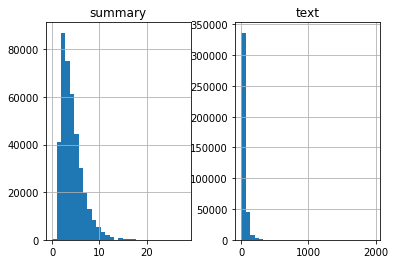

In [15]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in reviews_dataset['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in reviews_dataset['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

We shall consider max length for Reviews as 30 words and for summary as 8 words

In [16]:
count=0
for i in reviews_dataset['cleaned_summary']:
    if(len(i.split())<=8):
        count = count+1
print(count/len(reviews_dataset['cleaned_summary']))

0.9458310571316046


94.5% summary is covered within 8 words. So, we are good to go

In [0]:
max_text_len=30
max_summary_len=8

In [0]:
cleaned_text = np.array(reviews_dataset['cleaned_text'])
cleaned_summary = np.array(reviews_dataset['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
reviews_dataset  = pd.DataFrame({'text':short_text,'summary':short_summary})

In [0]:
reviews_dataset['summary'] = reviews_dataset['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

## Split the dataset into train and test

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(np.array(reviews_dataset['text']), np.array(reviews_dataset['summary']),test_size = 0.1,random_state = 3, \
                                                            shuffle = True)

## Text Tokenizer

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

## Rarewords and its Coverage

In [22]:
thresh = 2

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 46.83973818415452
Total Coverage of rare words: 0.6802727039447594


## Text to Sequence and Padding

In [23]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words = tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_validate_seq   =   x_tokenizer.texts_to_sequences(x_validate)

#padding zero upto maximum length
x_train    =   pad_sequences(x_train_seq,  maxlen = max_text_len, padding = 'post')
x_validate   =   pad_sequences(x_validate_seq, maxlen = max_text_len, padding = 'post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

x_voc

26478

## Summary Tokenizer

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

## Rarewords and its Coverage

In [25]:
thresh = 8

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if(value < thresh):
        cnt = cnt+1
        freq = freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 79.94533652203621
Total Coverage of rare words: 3.133851110624173


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words = tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_validate_seq   =   y_tokenizer.texts_to_sequences(y_validate) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen = max_summary_len, padding = 'post')
y_validate   =   pad_sequences(y_validate_seq, maxlen = max_summary_len, padding = 'post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [27]:
y_tokenizer.word_counts['sostok'],len(y_train)

(189227, 189227)

In [0]:
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j != 0:
            cnt = cnt+1
    if(cnt == 2):
        ind.append(i)

y_train = np.delete(y_train, ind, axis = 0)
x_train = np.delete(x_train, ind, axis = 0)

In [0]:
ind=[]
for i in range(len(y_validate)):
    cnt = 0
    for j in y_validate[i]:
        if j != 0:
            cnt = cnt+1
    if(cnt == 2):
        ind.append(i)

y_validate = np.delete(y_validate,ind, axis=0)
x_validate = np.delete(x_validate,ind, axis=0)

## Model building

In [0]:
backend.clear_session()
tf.reset_default_graph()

In [0]:
latent_dim = 300
embedding_dim = 100
batchsize = 128

In [32]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable = True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.2, recurrent_dropout = 0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.2, recurrent_dropout = 0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state = True, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape = (None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state=True,dropout = 0.2, recurrent_dropout = 0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state = [state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis = -1, name = 'concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation = 'softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      2647800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
_____________________________________________________________________________________________

In [0]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

In [0]:
history = model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], epochs = 20, callbacks = [es], batch_size = batchsize, \
                  validation_data = ([x_validate, y_validate[:,:-1]], y_validate.reshape(y_validate.shape[0], y_validate.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 185743 samples, validate on 20618 samples
Epoch 1/20
  9216/185743 [>.............................] - ETA: 7:19 - loss: 3.5633

## Understanding the Diagnostic plot

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'test')
pyplot.legend()
pyplot.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [0]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

## Inference

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape = (latent_dim,))
decoder_hidden_state_input = Input(shape = (max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis = -1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    encoder_out, encoder_h, encoder_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [encoder_out, encoder_h, encoder_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        encoder_h, encoder_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if((i != 0 and i != target_word_index['sostok']) and i != target_word_index['eostok']):
            newString = newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if(i != 0):
            newString = newString + reverse_source_word_index[i]+' '
    return newString

In [0]:
for i in range(0,100):
    print("Review:",seq2text(x_validate[i]))
    print("Original summary:", seq2summary(y_validate[i]))
    print("Predicted summary:", decode_sequence(x_validate[i].reshape(1,max_text_len)))
    print("\n")